# Analysis

Notebook author: Martin Saveski (msaveski@mit.edu)

Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the LICENSE file in the root directory of this source tree.

In [1]:
# load libraries
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(scales))

In [2]:
# setup
setwd("~/code/social-catalysts")

source("scripts/utils.R")

dta_root <- "data/"
plt_root <- "figs_cscw/"

theme_set(theme_light())

colors = c("Catalyst" = "#ee0001", "Matched" = "#3b4992")

# Posts Analysis

## Topics (Fig 2)

In [3]:
df_empath <- readRDS(str_c(dta_root, "post_analysis/empath.rds"))

df_empath <- df_empath %>%
  ungroup() %>%
  mutate(post_cm = str_to_title(post_cm))

In [4]:
# (A) counts
plt_empath <- df_empath %>%
  ggplot(aes(
    x = fct_reorder(topic, m),
    y = m,
    fill = fct_rev(post_cm)
  )) +
  geom_bar(stat = "identity",
           position = position_dodge(),
           width = 0.7) +
  geom_errorbar(
    aes(ymin = low_ci, ymax = high_ci),
    position = position_dodge(width = 0.7),
    color = "black",
    size = 0.3,
    width = 0.5
  ) +
  labs(x = NULL, y = "Average Count", fill = NULL) +
  scale_fill_manual(values = colors) +
  coord_flip() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    legend.position = "none"
  )

In [5]:
# (B) differences
df_empath_dd <- df_empath %>%
  select(post_cm, topic, m, se) %>%
  mutate(post_cm = str_to_lower(post_cm)) %>%
  multi_spread(post_cm, c(m, se)) %>%
  mutate(
    d_m = catalyst_m - matched_m,
    d_se = sqrt(catalyst_se^2 + matched_se^2), 
    d_ci = 1.96 * d_se,
    d_m_low = d_m - d_ci,
    d_m_high = d_m + d_ci
  ) %>%
  arrange(desc(d_m))

# variables for coloring the CIs
df_empath_dd <- df_empath_dd %>%
  mutate(
    b_start = case_when(
      d_m_low > 0 & d_m_high > 0 ~ d_m,
      d_m_low < 0 & d_m_high > 0 ~ d_m_low,
      d_m_low < 0 & d_m_high < 0 ~ d_m_low
    ),
    b_end = case_when(
      d_m_low > 0 & d_m_high > 0 ~ d_m_high,
      d_m_low < 0 & d_m_high > 0 ~ d_m_high,
      d_m_low < 0 & d_m_high < 0 ~ d_m
    ),
    w_start = case_when(
      d_m_low > 0 & d_m_high > 0 ~ d_m_low,
      d_m_low < 0 & d_m_high > 0 ~ 0,
      d_m_low < 0 & d_m_high < 0 ~ d_m
    ),
    w_end = case_when(
      d_m_low > 0 & d_m_high > 0 ~ d_m,
      d_m_low < 0 & d_m_high > 0 ~ d_m,
      d_m_low < 0 & d_m_high < 0 ~ d_m_high
    )
  )

plt_empath_dd <- df_empath_dd %>%
  ggplot(aes(x = fct_reorder(topic, d_m), y = d_m)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_errorbar(
    aes(ymin = b_start, ymax = b_end),
    width = 0,
    color = "black",
    size = 0.8
  ) +
  geom_errorbar(
    aes(ymin = w_start, ymax = w_end),
    width = 0,
    color = "white",
    size = 0.8
  ) +
  labs(x = "", y = "Catalyst - Matched") +
  scale_x_discrete(position = "top") +
  scale_y_continuous(breaks = pretty_breaks(), limits = c(-0.01, 0.04)) +
  coord_flip()  +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank())

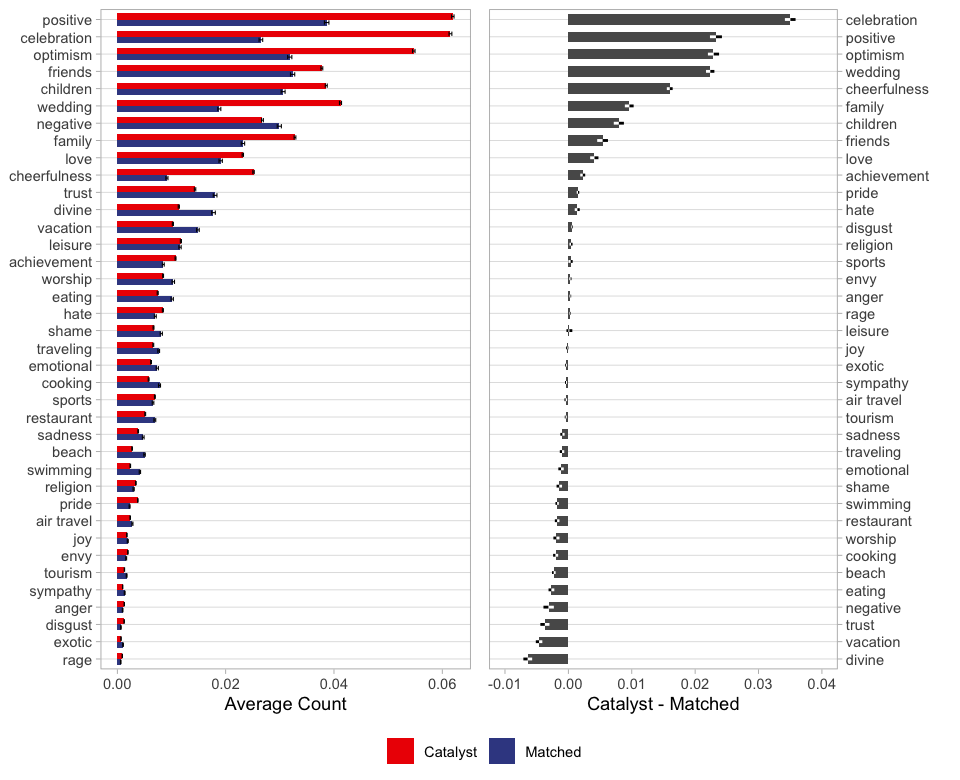

In [6]:
p_row <- plot_grid(plt_empath, plt_empath_dd, ncol = 2, align = "h")
legend <- get_legend(
  plt_empath + 
    guides(fill = guide_legend(reverse = T)) + 
    theme(legend.position="bottom")
)
plt_empath_full <- plot_grid(p_row, legend, ncol=1, rel_heights = c(1, .08))

options(repr.plot.width=8, repr.plot.height=6.5)
print(plt_empath_full)

# User Analysis

## Ego networks (Fig 3)

In [7]:
df_ego_stats <- readRDS(str_c(dta_root, "user_ego_nets_sample/ego_stats.rds"))

df_ego_stats_inc <- df_ego_stats %>%
  ungroup() %>%
  select(is_catalyst, field, m, se) %>%
  multi_spread(is_catalyst, c(m, se)) %>%
  group_by(field) %>%
  do(
    per_change_delta_se(
      .$catalyst_m, .$matched_m,
      .$catalyst_se, .$matched_se
    )
  )

ego_stats_fields <- c(
  "n_nodes",
  "density",
  "avg_clust",
  "avg_degree",
  "var_degrees",
  "deg_assortativity",
  "fiedler",
  "modularity"
)

df_ego_stats_inc <- df_ego_stats_inc %>%
  ungroup() %>%
  filter(field %in% ego_stats_fields) %>%
  mutate(
    field = case_when(
      field == "n_nodes" ~ "Number of Nodes (Friends)",
      field == "density" ~ "Density",
      field == "avg_degree" ~ "Degree Average",
      field == "var_degrees" ~ "Degree Variance",
      field == "deg_assortativity" ~ "Degree Assortativity",
      field == "fiedler" ~ "Algebraic Connectivity",
      field == "avg_clust" ~ "  Average Clustering Coefficient",
      field == "modularity" ~ "Modularity"
    ),
    field = factor(
      field,
      levels = rev(c(
        "Number of Nodes (Friends)",
        "Number of Edges",
        "Density",
        "Degree Average",
        "Degree Variance",
        "Degree Assortativity",
        "  Average Clustering Coefficient",
        "Algebraic Connectivity",
        "Modularity"
      )
      ))
  )

plt_ego_stats_inc <- df_ego_stats_inc %>%
  ggplot(aes(
    x = field,
    y = mean,
    ymin = lower95,
    ymax = upper95
  )) +
  geom_point(size = 2) +
  geom_errorbar(width = 0, size = 0.6) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  labs(x = NULL, y = "Catalyst vs Matched users (% increase)") +
  scale_y_continuous(labels = percent_format(accuracy = 1),
                     limits = c(-0.013, 0.3)) +
  scale_color_aaas() +
  coord_flip() +
  theme(
    axis.ticks = element_blank(),
    strip.text.y = element_text(color = "black", angle = 0),
    strip.background.y = element_rect(fill = "grey90"),
    legend.position = "none"
  )

In [8]:
# k-core
df_ego_k_core <- readRDS(str_c(dta_root, "user_ego_nets_sample/k_core.rds"))

df_ego_k_core <- df_ego_k_core %>% ungroup() %>% filter(threshold < 16)

plt_ego_k_core <- df_ego_k_core %>%
  ggplot(aes(x = threshold, y = m, color=is_catalyst)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=low_ci, ymax=high_ci), width=0.2) +
  scale_x_continuous(trans = log2_trans(),
                     breaks = c(2, 4, 8),
                     labels = c(expression(2^1), expression(2^2), expression(2^3))) +
  labs(x = "k", y = "Components in k-core", color = NULL) +
  expand_limits(y = 1) +
  guides(color = guide_legend(reverse = T)) +
  scale_color_aaas() +
  theme(
    panel.grid.minor.y = element_blank(),
    legend.position="bottom"
  )

In [9]:
# k brace
df_ego_k_truss <- readRDS(str_c(dta_root, "user_ego_nets_sample/k_truss.rds"))

df_ego_k_truss <- df_ego_k_truss %>% ungroup() %>% filter(threshold < 16)

plt_ego_k_truss <- df_ego_k_truss %>%
  ggplot(aes(x = threshold, y = m, color=is_catalyst)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=low_ci, ymax=high_ci), width=0.2) +
  scale_x_continuous(trans = log2_trans(),
                     breaks = c(2, 4, 8),
                     labels = c(expression(2^1), expression(2^2), expression(2^3))) +
  scale_y_continuous(breaks = seq(1, 8, by = 1)) +
  labs(x = "k", y = "Components in k-brace", color = NULL) +
  expand_limits(y = 1) +
  guides(color = guide_legend(reverse = T)) +
  scale_color_aaas() +
  theme(
    panel.grid.minor.y = element_blank(),
    legend.position="bottom"
  )

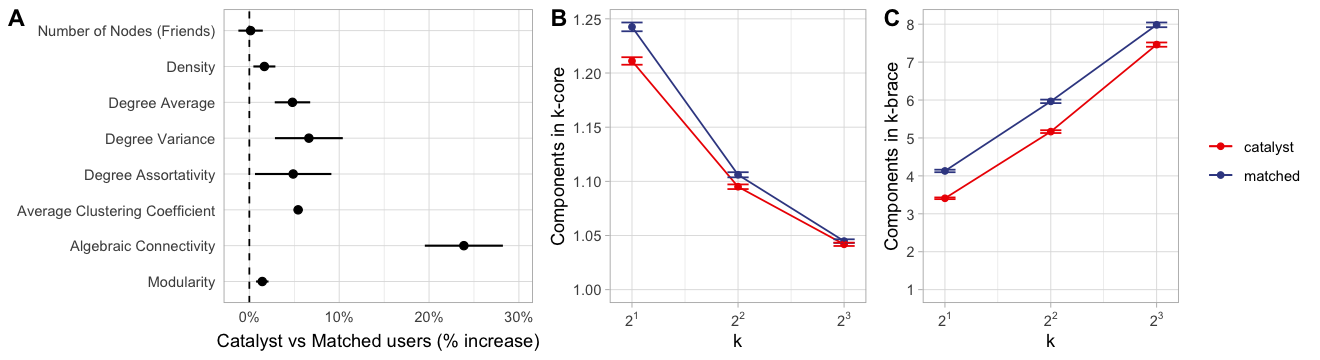

In [10]:
# group figures
plt_ego_nets_all <- plot_grid(
  plt_ego_stats_inc,
  plt_ego_k_core + theme(legend.position="none"), 
  plt_ego_k_truss + theme(legend.position="right"), 
  labels = c('A', 'B', 'C'),
  nrow = 1,
  rel_widths = c(1, 0.615, 0.82), 
  align = "h"
)

options(repr.plot.width=11, repr.plot.height=3)
print(plt_ego_nets_all)

# Survey

## Questions Overlap (Fig 5)

Warning message:
“Removed 4 rows containing missing values (geom_text).”


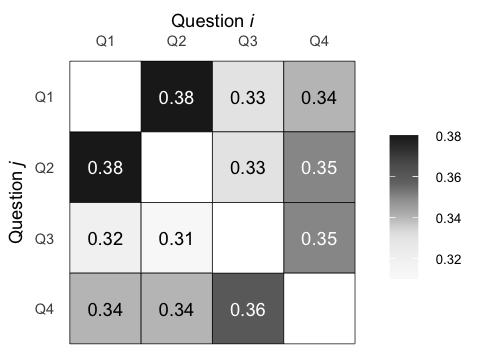

In [11]:
df_overlap <- readRDS(str_c(dta_root, "survey/overlap.rds"))

df_overlap <- df_overlap %>%
  mutate(col = ifelse(v > 0.345, "white", "black"))

plt_overlap <- df_overlap %>%
  ggplot(aes(q_i, fct_rev(q_j), fill = v)) +
  geom_tile() +
  geom_tile(color = "black", linetype = 1, size = 0.2) +
  geom_text(aes(label = v, color = col)) + 
  scale_fill_material("grey", na.value = 'white') + 
  scale_color_manual(values = c("black", "white")) + 
  scale_x_discrete(position = "top") +
  labs(
    x = expression(paste("Question ", italic("i"))), 
    y = expression(paste("Question ", italic("j")))
  ) +
  guides(
    color = F,
    fill = guide_colourbar(
      draw.ulim = FALSE, 
      draw.llim = FALSE,
      label.theme = element_text(colour = "black", size = 8, margin = margin(l=5))
    )) +
  theme(
    axis.ticks = element_blank(),
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    legend.title = element_blank(),
    legend.position = "right"
  )

options(repr.plot.width=4, repr.plot.height=3)
print(plt_overlap)

## Nominated Percentiles (Fig 6)

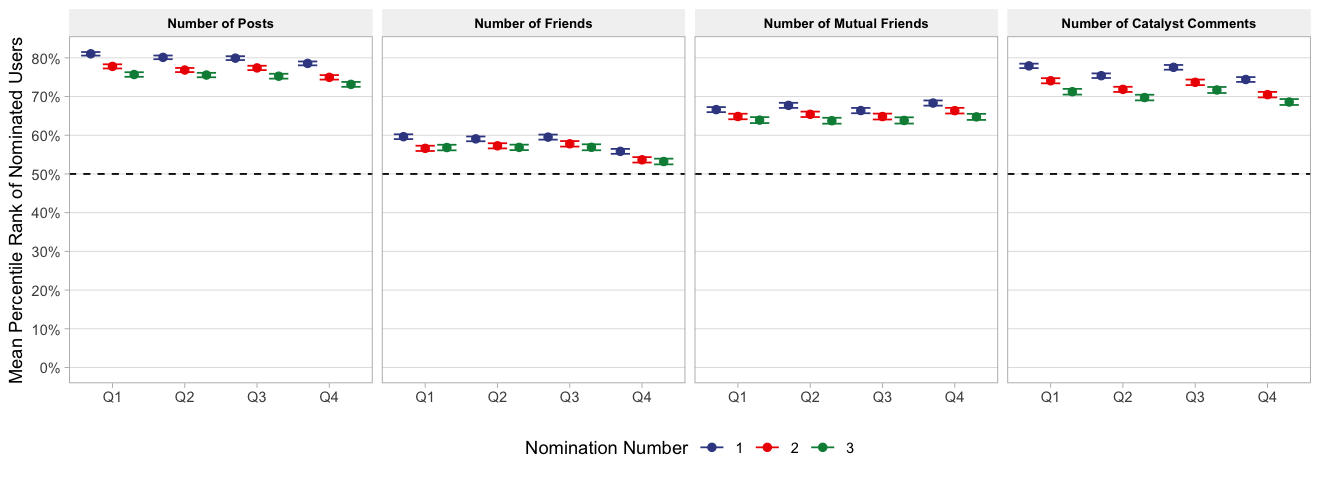

In [12]:
df_nom_percentiles <- readRDS(
  str_c(
    dta_root,
    "survey_nominated_percentiles/nominated_percentile_per_nomination.rds"
  )
)

df_nom_percentiles <- df_nom_percentiles %>%
  ungroup() %>%
  filter(field != 'catalyst comments (per post)') %>%
  mutate(
    field = case_when(
      field == "posts" ~ "Number of Posts",
      field == "catalyst comments (total)" ~ "Number of Catalyst Comments",
      field == "mutual friends" ~ "Number of Mutual Friends",
      field == "friends" ~ "Number of Friends"
    ),
    field = factor(
      field,
      levels = c(
        "Number of Posts",
        "Number of Friends",
        "Number of Mutual Friends",
        "Number of Catalyst Comments"
      )
    ),
    nomination_number = case_when(
      nomination_number == "0" ~ "1",
      nomination_number == "1" ~ "2",
      nomination_number == "2" ~ "3"
    ),
    question_code = str_to_upper(question_code)
  )

plt_nom_percentiles <- df_nom_percentiles %>%
  ggplot(aes(x = question_code, y = m, color = nomination_number)) +
  geom_point(size = 2, position = position_dodge(0.9)) +
  geom_errorbar(aes(ymin = low_ci, ymax = high_ci),
                width = 0.8,
                position = position_dodge(0.9)) +
  geom_hline(aes(yintercept = 0.5), linetype = "dashed") +
  facet_wrap(~ field, ncol = 4) +
  labs(x = NULL, y = "Mean Percentile Rank of Nominated Users", color = "Nomination Number") +
  scale_y_continuous(labels = percent_format(accuracy = 1),
                     breaks = seq(0, 0.8, 0.1)) +
  expand_limits(y = 0) +
  scale_color_aaas() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    strip.text.x = element_text(color = "black", size = 8, face = "bold"),
    strip.background.x = element_rect(fill = "grey95"),
    legend.position = "bottom"
  )

options(repr.plot.width=11, repr.plot.height=4)
print(plt_nom_percentiles)

## Percent Increase in Mean Catalystness (Fig 7)

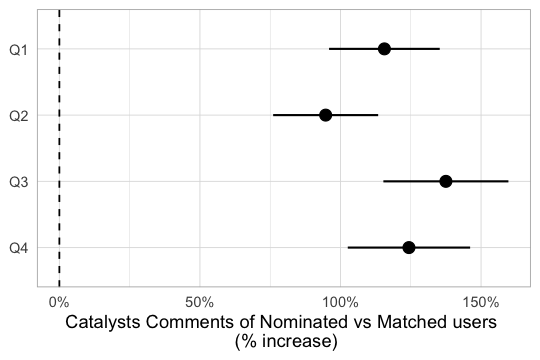

In [13]:
df_tot_cat_per_q <- readRDS(str_c(
  dta_root,
  "survey_catalystness_per_question/tot_catalystness.rds"
))

df_tot_cat_per_q <- df_tot_cat_per_q %>%
  ungroup() %>%
  mutate(question_code = str_to_upper(question_code)) %>% 
  rename(
    mean = avg_total_cat,
    std = std_total_cat
  ) %>%
  multi_spread(is_nominated, c(mean, std, n))

df_tot_cat_per_q_inc <- df_tot_cat_per_q %>%
  group_by(question_code) %>%
  do(
    per_change_delta(
      .$nominated_mean, .$matched_mean,
      .$nominated_n, .$matched_n,
      .$nominated_std, .$matched_std
    )
  )

plt_cat_total_inc <- df_tot_cat_per_q_inc %>%
  ggplot(aes(x = fct_rev(question_code), y = mean)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = lower95, ymax = upper95), width = 0, size = 0.6) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  labs(x = NULL, y = "Catalysts Comments of Nominated vs Matched users \n (% increase)") +
  scale_y_continuous(labels = percent) +
  expand_limits(y = 0) + 
  coord_flip() + 
  theme(
    axis.ticks = element_blank()
  )

options(repr.plot.width=4.5, repr.plot.height=3)
print(plt_cat_total_inc)